In [1]:
from NuScenes import *
import os
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points, transform_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
data_dir = "/shared/data/nuScenes/"
sensors = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
    vname : NuScenes(dataroot=data_dir, version=version, verbose=False)\
    for vname,version in versions.items()
}

In [3]:
def get_front_camera_images(nusc, first_sample_token):
    front_camera_images = []
    current_sample_token = first_sample_token
    
    while current_sample_token != '':
        # Get the sample
        sample = nusc.get('sample', current_sample_token)
        
        # Get front camera data
        cam_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
        
        # Read the image
        cam_image_path = nusc.get_sample_data_path(cam_data['token'])
        cam_image = cv2.imread(cam_image_path)
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB)
        
        front_camera_images.append(cam_image)
        
        # Move to the next sample in the scene
        current_sample_token = sample['next']
    
    return front_camera_images

In [4]:
nusc = nuscenes_exp['trainval']

In [11]:
seq = 345
data_dir = "/shared/data/nuScenes/"
ref_frame = 'global'
num_sweeps = 1
ref_sensor = None
apply_dpr = True
filter_points = False
dpr_thresh = 0.01

# dataset_sequence = NuScenesMultipleRadar(nusc=nusc, data_dir=data_dir,
#                                 sequence=seq,
#                                 sensors=["RADAR_FRONT"])


dataset_sequence = NuScenesMultipleRadarMultiSweeps(
    data_dir=data_dir,
    nusc=nusc,
    sequence=seq,
    sensors=sensors,
    nsweeps=num_sweeps,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    apply_dpr=apply_dpr,
    filter_points=filter_points,
    ransac_threshold=dpr_thresh

)

In [6]:
cam_dataset_sequence = get_front_camera_images(nusc, dataset_sequence.scene['first_sample_token'])

pointclouds = [frame[0] for frame in dataset_sequence]

# # Visualize the two sequences side-by-side as a video
# anim = create_sequence_video(cam_dataset_sequence, pointclouds)
# HTML(anim.to_jshtml())

### Alternate Visualization

In [7]:
def visualize_scene(scene_name, output_video_path, fps=3, zoom_percentage=0.5):
    # Find the scene
    scene = next(s for s in nusc.scene if s['name'] == scene_name)
    scene_token = scene['token']
    
    # Get all the samples in the scene
    sample_tokens = []
    current_sample_token = scene['first_sample_token']
    while current_sample_token != '':
        sample_tokens.append(current_sample_token)
        current_sample_token = nusc.get('sample', current_sample_token)['next']
    
    frames = []
    for sample_token in sample_tokens:
        sample = nusc.get('sample', sample_token)
        
        # Get ego pose
        ego_pose = nusc.get('ego_pose', nusc.get('sample_data', sample['data']['LIDAR_TOP'])['ego_pose_token'])
        
        # Get LIDAR_TOP point cloud
        lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
        pcl_path = nusc.get_sample_data_path(lidar_data['token'])
        pc = LidarPointCloud.from_file(pcl_path)
        
        # Transform the point cloud to the global frame
        translation = ego_pose['translation']
        rotation = Quaternion(ego_pose['rotation'])
        transform = clear_z_one_pose(transform_matrix(translation, rotation, inverse=False))
        # pc.transform(transform)

        mask = pc.points[2, : ] > -1.5
        pc.points = pc.points[:, mask]
        
        # Get front camera image
        cam_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
        cam_image = cv2.imread(nusc.get_sample_data_path(cam_data['token']))
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB)
        
        # Create BEV image with the same size as the camera image
        bev_image = create_bev_image(nusc, sample, pc, cam_image.shape[1], cam_image.shape[0], zoom_percentage)
        
        # Combine images side by side
        combined_image = combine_images(bev_image, cam_image)
        frames.append(combined_image)
    
    # Create video
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(output_video_path, codec='libx264')

# def create_bev_image(pointcloud, width, height, zoom_percentage):
#     fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
#     points = pointcloud[:, :2].T #.points[:2, :]
    
#     # Calculate the range of the point cloud
#     min_x, max_x = np.min(points[0, :]), np.max(points[0, :])
#     min_y, max_y = np.min(points[1, :]), np.max(points[1, :])
    
#     # Calculate zoom limits
#     range_x = max_x - min_x
#     range_y = max_y - min_y
#     center_x = (min_x + max_x) / 2
#     center_y = (min_y + max_y) / 2
    
#     zoom_x = range_x * zoom_percentage / 2
#     zoom_y = range_y * zoom_percentage / 2
    
#     ax.scatter(points[0, :], points[1, :], s=3)
    
#     ax.set_aspect('equal', adjustable='box')
#     ax.axis('off')
    
#     # Set dynamic zoom limits
#     ax.set_xlim(center_x - zoom_x, center_x + zoom_x)
#     ax.set_ylim(center_y - zoom_y, center_y + zoom_y)
    
#     # Convert plot to image
#     fig.canvas.draw()
#     data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#     data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     plt.close(fig)
    
#     return data



def create_bev_image(nusc, sample, pointcloud, width, height, zoom_percentage):
    from nuscenes.utils.data_classes import Box
    fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
    points = pointcloud.points[:2, :]
    
    # Calculate the range of the point cloud
    min_x, max_x = np.min(points[0, :]), np.max(points[0, :])
    min_y, max_y = np.min(points[1, :]), np.max(points[1, :])
    
    # Calculate zoom limits
    range_x = max_x - min_x
    range_y = max_y - min_y
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    
    zoom_x = range_x * zoom_percentage / 2
    zoom_y = range_y * zoom_percentage / 2
    
    ax.scatter(points[0, :], points[1, :], s=0.2, c='k')
    
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    
    # Set dynamic zoom limits
    # ax.set_xlim(center_x - zoom_x, center_x + zoom_x)
    # ax.set_ylim(center_y - zoom_y, center_y + zoom_y)

    # Plot 3D bounding boxes with class labels
    for ann_token in sample['anns']:
        ann = nusc.get('sample_annotation', ann_token)
        box = Box(ann['translation'], ann['size'], Quaternion(ann['rotation']))
        color = np.array(nusc.colormap[ann['category_name']]) / 255.0
        corners = view_points(box.corners(), view=np.eye(3), normalize=False)[:2, :]
        ax.add_patch(plt.Polygon(corners.T, closed=True, edgecolor=color, fill=False, linewidth=1))
        ax.text(ann['translation'][0], ann['translation'][1], ann['category_name'], color=color)
    
    # Convert plot to image
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    
    return data

def combine_images(bev_image, cam_image):
    height = max(bev_image.shape[0], cam_image.shape[0])
    width = bev_image.shape[1] + cam_image.shape[1]
    
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)
    combined_image[:bev_image.shape[0], :bev_image.shape[1], :] = bev_image
    combined_image[:cam_image.shape[0], bev_image.shape[1]:, :] = cam_image
    
    return combined_image

In [8]:

# # Example usage
# scene_name = 'scene-0103'  # Replace with your scene name
# output_video_path = f'{scene_name}_video.mp4'
# visualize_scene(scene_name, output_video_path)

In [9]:
# # Create BEV image with the same size as the camera image
# frames = [
#       combine_images(
#             create_bev_image(pc, cam_image.shape[1], cam_image.shape[0], 0.15),
#             cam_image
#             )\
#             for pc,cam_image in zip(pointclouds, cam_dataset_sequence)
# ]
# scene_name = 'scene-0103'  # Replace with your scene name
# output_video_path = f'{scene_name}_video.mp4'
# # Create video
# clip = ImageSequenceClip(frames, fps=10)
# clip.write_videofile(output_video_path, codec='libx264')

In [10]:
def get_sps_labels(map, scan_points):
    labeled_map_points = map[:, :3]
    labeled_map_labels = map[:, -1]

    sps_labels = []
    for point in scan_points[:, :3]:
        distances = np.linalg.norm(labeled_map_points - point, axis=1)
        closest_point_idx = np.argmin(distances)
        sps_labels.append(labeled_map_labels[closest_point_idx])
    sps_labels = np.array(sps_labels)
    return sps_labels

In [11]:
def map_pointcloud_to_image(nusc,
                            sps_map,
                            pointsensor_token: str,
                            camera_token: str,
                            min_dist: float = 1.0,
                            render_intensity: bool = False,
                            show_lidarseg: bool = False,
                            filter_lidarseg_labels: List = None,
                            lidarseg_preds_bin_path: str = None,
                            show_panoptic: bool = False):
    """
    Given a point sensor (lidar/radar) token and camera sample_data token, load pointcloud and map it to the image
    plane.
    :param pointsensor_token: Lidar/radar sample_data token.
    :param camera_token: Camera sample_data token.
    :param min_dist: Distance from the camera below which points are discarded.
    :param render_intensity: Whether to render lidar intensity instead of point depth.
    :param show_lidarseg: Whether to render lidar intensity instead of point depth.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
        or the list is empty, all classes will be displayed.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        If show_lidarseg is True, show_panoptic will be set to False.
    :return (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
    """

    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)

    pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
    if pointsensor['sensor_modality'] == 'lidar':
        if show_lidarseg or show_panoptic:
            gt_from = 'lidarseg' if show_lidarseg else 'panoptic'
            assert hasattr(nusc, gt_from), f'Error: nuScenes-{gt_from} not installed!'

            # Ensure that lidar pointcloud is from a keyframe.
            assert pointsensor['is_key_frame'], \
                'Error: Only pointclouds which are keyframes have lidar segmentation labels. Rendering aborted.'

            assert not render_intensity, 'Error: Invalid options selected. You can only select either ' \
                                            'render_intensity or show_lidarseg, not both.'

        pc = LidarPointCloud.from_file(pcl_path)
    else:
        pc = RadarPointCloud.from_file(pcl_path)
    im = Image.open(osp.join(nusc.dataroot, cam['filename']))
    

    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))


    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    global_points = pc.points.T
    sps_score = get_sps_labels(sps_map, global_points)

    # plt.figure(figsize=(10,5))
    # plt.scatter(sps_map[:, 0], sps_map[:, 1], label='sps_map', s=size)
    # plt.scatter(global_points[:, 0], global_points[:, 1], label='global_frame', s=size)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.legend()
    # plt.show()

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)
    
    # Fourth step: transform from ego into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)


    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]

    if render_intensity:
        assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render intensity for lidar, ' \
                                                            'not %s!' % pointsensor['sensor_modality']
    else:
        # Retrieve the color from the depth.
        coloring = sps_score

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]

    return points, coloring, im

def render_pointcloud_in_image(nusc,
                               sps_map,
                                sample_token: str,
                                dot_size: int = 5,
                                pointsensor_channel: str = 'LIDAR_TOP',
                                camera_channel: str = 'CAM_FRONT',
                                out_path: str = None,
                                render_intensity: bool = False,
                                show_lidarseg: bool = False,
                                filter_lidarseg_labels: List = None,
                                ax = None,
                                show_lidarseg_legend: bool = False,
                                verbose: bool = True,
                                lidarseg_preds_bin_path: str = None,
                                show_panoptic: bool = False):
    """
    Scatter-plots a pointcloud on top of image.
    :param sample_token: Sample token.
    :param dot_size: Scatter plot dot size.
    :param pointsensor_channel: RADAR or LIDAR channel name, e.g. 'LIDAR_TOP'.
    :param camera_channel: Camera channel name, e.g. 'CAM_FRONT'.
    :param out_path: Optional path to save the rendered figure to disk.
    :param render_intensity: Whether to render lidar intensity instead of point depth.
    :param show_lidarseg: Whether to render lidarseg labels instead of point depth.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes.
    :param ax: Axes onto which to render.
    :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
    :param verbose: Whether to display the image in a window.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        If show_lidarseg is True, show_panoptic will be set to False.
    """
    if show_lidarseg:
        show_panoptic = False
    sample_record = nusc.get('sample', sample_token)


    # Here we just grab the front camera and the point sensor.
    pointsensor_token = nusc.get('sample_data', sample_record['data'][pointsensor_channel])['token'] # sample_record['data'][pointsensor_channel]
    camera_token = nusc.get('sample_data', sample_record['data'][camera_channel])['token'] # sample_record['data'][camera_channel]

    points, coloring, im = map_pointcloud_to_image(nusc, sps_map, pointsensor_token, camera_token,
                                                        render_intensity=render_intensity,
                                                        show_lidarseg=show_lidarseg,
                                                        filter_lidarseg_labels=filter_lidarseg_labels,
                                                        lidarseg_preds_bin_path=lidarseg_preds_bin_path,
                                                        show_panoptic=show_panoptic)

    # Init axes.
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(9, 16))
        if lidarseg_preds_bin_path:
            fig.canvas.set_window_title(sample_token + '(predictions)')
        else:
            fig.canvas.set_window_title(sample_token)
    else:  # Set title on if rendering as part of render_sample.
        ax.set_title(camera_channel)
    ax.imshow(im)
    scatter = ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size, cmap='RdYlGn')
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ax.axis('off')
    # fig.colorbar(im, label='Stability', orientation='horizontal')
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label("Stability (Max: 1)")

    # Produce a legend with the unique colors from the scatter.
    if pointsensor_channel == 'LIDAR_TOP' and (show_lidarseg or show_panoptic) and show_lidarseg_legend:
        # If user does not specify a filter, then set the filter to contain the classes present in the pointcloud
        # after it has been projected onto the image; this will allow displaying the legend only for classes which
        # are present in the image (instead of all the classes).
        if filter_lidarseg_labels is None:
            if show_lidarseg:
                # Since the labels are stored as class indices, we get the RGB colors from the
                # colormap in an array where the position of the RGB color corresponds to the index
                # of the class it represents.
                color_legend = colormap_to_colors(nusc.colormap, nusc.lidarseg_name2idx_mapping)
                filter_lidarseg_labels = get_labels_in_coloring(color_legend, coloring)
            else:
                # Only show legends for all stuff categories for panoptic.
                filter_lidarseg_labels = stuff_cat_ids(len(nusc.lidarseg_name2idx_mapping))

    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)
    if verbose:
        plt.show()

In [12]:
import os
import cv2
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud

def setup_directories(scene_name, subdirs=False):
    os.makedirs(scene_name, exist_ok=True)
    if subdirs:
        os.makedirs(os.path.join(scene_name, 'plot1_scene1'), exist_ok=True)
        os.makedirs(os.path.join(scene_name, 'plot1_scene2'), exist_ok=True)
        os.makedirs(os.path.join(scene_name, 'plot2_scene1'), exist_ok=True)
        os.makedirs(os.path.join(scene_name, 'plot2_scene2'), exist_ok=True)
    else:
        os.makedirs(os.path.join(scene_name, 'plot1'), exist_ok=True)
        os.makedirs(os.path.join(scene_name, 'plot2'), exist_ok=True)

def save_plots_for_scene(nusc, scene_name, sample_token, sps_map, plot_suffix=""):
    sample = nusc.get('sample', sample_token)


    frame_index = 0
    if len(plot_suffix):
        plot_suffix = "_" + plot_suffix
    
    while sample_token:
        # sd_rec = nusc.get('sample_data', next_sample_rec['data']['CAM_FRONT'])
        # pointsensor = nusc.get('sample_data', next_sample_rec['data']['RADAR_FRONT']) 
        # Save first type of plot
        
        plot1_path = os.path.join(scene_name, f'plot1{plot_suffix}', f'{frame_index}.png')
        nusc.render_sample_data(sample['data']['RADAR_FRONT'], nsweeps=7, underlay_map=True, with_anns=True, out_path=plot1_path)
        
        # Save second type of plot
        plot2_path = os.path.join(scene_name, f'plot2{plot_suffix}', f'{frame_index}.png')
        render_pointcloud_in_image(nusc, sps_map, sample['token'], pointsensor_channel='RADAR_FRONT', out_path=plot2_path)
        
        # Move to next sample
        sample_token = sample['next']
        if sample_token:
            sample = nusc.get('sample', sample_token)
        frame_index += 1

def create_combined_video_from_plots(scene_name):
    plot1_dir_scene1 = os.path.join(scene_name, 'plot1_scene1')
    plot2_dir_scene1 = os.path.join(scene_name, 'plot2_scene1')
    plot1_dir_scene2 = os.path.join(scene_name, 'plot1_scene2')
    plot2_dir_scene2 = os.path.join(scene_name, 'plot2_scene2')
    
    plot1_images_scene1 = sorted(os.listdir(plot1_dir_scene1))
    plot2_images_scene1 = sorted(os.listdir(plot2_dir_scene1))
    plot1_images_scene2 = sorted(os.listdir(plot1_dir_scene2))
    plot2_images_scene2 = sorted(os.listdir(plot2_dir_scene2))
    
    if not plot1_images_scene1 or not plot2_images_scene1 or len(plot1_images_scene1) != len(plot2_images_scene1) or \
       not plot1_images_scene2 or not plot2_images_scene2 or len(plot1_images_scene2) != len(plot2_images_scene2):
        raise ValueError("Mismatch or missing frames between the plot directories")
    
    sample_image1_scene1 = cv2.imread(os.path.join(plot1_dir_scene1, plot1_images_scene1[0]))
    sample_image2_scene1 = cv2.imread(os.path.join(plot2_dir_scene1, plot2_images_scene1[0]))
    sample_image1_scene2 = cv2.imread(os.path.join(plot1_dir_scene2, plot1_images_scene2[0]))
    sample_image2_scene2 = cv2.imread(os.path.join(plot2_dir_scene2, plot2_images_scene2[0]))

    size = (640, 360)

    video_height = 2 * size[1]
    video_width = 2 * size[0]
    
    out_video_path = os.path.join(scene_name, 'output_video.avi')
    out = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 5, (video_width, video_height))
    
    for img1_name_scene1, img2_name_scene1, img1_name_scene2, img2_name_scene2 in zip(plot1_images_scene1, plot2_images_scene1, plot1_images_scene2, plot2_images_scene2):
        img1_scene1 = cv2.imread(os.path.join(plot1_dir_scene1, img1_name_scene1))
        img2_scene1 = cv2.imread(os.path.join(plot2_dir_scene1, img2_name_scene1))
        img1_scene2 = cv2.imread(os.path.join(plot1_dir_scene2, img1_name_scene2))
        img2_scene2 = cv2.imread(os.path.join(plot2_dir_scene2, img2_name_scene2))

        img1_scene1 = cv2.resize(img1_scene1, size)
        img2_scene1 = cv2.resize(img2_scene1, size)
        img1_scene2 = cv2.resize(img1_scene2, size)
        img2_scene2 = cv2.resize(img2_scene2, size)
        
        stacked_image_scene1 = cv2.vconcat([img1_scene1, img2_scene1])
        stacked_image_scene2 = cv2.vconcat([img1_scene2, img2_scene2])
        combined_image = cv2.hconcat([stacked_image_scene1, stacked_image_scene2])
        
        out.write(combined_image)
    
    out.release()


def create_video_from_plots(scene_name):
    plot1_dir = os.path.join(scene_name, 'plot1')
    plot2_dir = os.path.join(scene_name, 'plot2')
    
    plot1_images = sorted(os.listdir(plot1_dir))
    plot2_images = sorted(os.listdir(plot2_dir))
    
    if not plot1_images or not plot2_images or len(plot1_images) != len(plot2_images):
        raise ValueError("Mismatch or missing frames between the plot directories")
    
    sample_image1 = cv2.imread(os.path.join(plot1_dir, plot1_images[0]))
    sample_image2 = cv2.imread(os.path.join(plot2_dir, plot2_images[0]))

    size = (1280, 720)

    
    height1, width1, _ = sample_image1.shape
    height2, width2, _ = sample_image2.shape
    
    video_height = 2 * size[1] # height1 + height2
    video_width = size[0] # width1
    
    out_video_path = os.path.join(scene_name, 'output_video.avi')
    out = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 5, (video_width, video_height))
    
    for img1_name, img2_name in zip(plot1_images, plot2_images):
        img1 = cv2.imread(os.path.join(plot1_dir, img1_name))
        img2 = cv2.imread(os.path.join(plot2_dir, img2_name))

        img1 = cv2.resize(img1, size)
        img2 = cv2.resize(img2, size)
        
        stacked_image = cv2.vconcat([img1, img2])
        out.write(stacked_image)
    
    out.release()

In [13]:
# sample_token = dataset_sequence.scene['first_sample_token']
# sample = nusc.get('sample', sample_token)

# RadarPointCloud.disable_filters()
# nusc.render_sample_data(sample['data']['RADAR_FRONT'], nsweeps=1, underlay_map=True, with_anns=True)


# nusc.render_pointcloud_in_image(sample['token'], pointsensor_channel='RADAR_FRONT', out_path='frame.png')

In [14]:
scene_name = 'scene-0151'
labelled_map_path = "scene-0151.asc"
sps_map = np.loadtxt(labelled_map_path, delimiter=' ', skiprows=1)

sample_token = dataset_sequence.scene['first_sample_token']
def get_next_sample(sample):
    return nusc.get('sample', sample['next'])

sample = nusc.get('sample', sample_token)
sample

{'token': '090e988105f943718f7c8b823b49b44b',
 'timestamp': 1533114326646252,
 'prev': '',
 'next': '2571d511a87a4f818e27bc4de69c1501',
 'scene_token': 'ba76f4185aa34ed3bff467ac640da902',
 'data': {'RADAR_FRONT': '09bfff030a784e0883d72ed57bd6b3a8',
  'RADAR_FRONT_LEFT': 'f2172b69cad141c888b108962673d78a',
  'RADAR_FRONT_RIGHT': '869dcc120dbd45acb0a9629f310dbf1f',
  'RADAR_BACK_LEFT': 'f73957b76a48412d9e464e1e5e486fe0',
  'RADAR_BACK_RIGHT': '1dbbc0a781834df3848669c1de12001e',
  'LIDAR_TOP': '4f59f1deefb14911a50daa1e2a0c5c17',
  'CAM_FRONT': '2900da405dec4e98b626b2088c5bb473',
  'CAM_FRONT_RIGHT': '69feab3091004babb2a6cc23b6295645',
  'CAM_BACK_RIGHT': '826a35dbf6c24827bd95a7fb0f3df4fc',
  'CAM_BACK': '3f166f2123314b9f80ccbc2aec4b85d8',
  'CAM_BACK_LEFT': '98a8d159ae844b9e8c5dba5d3af46c2d',
  'CAM_FRONT_LEFT': '0c947b6d664e47f99033c6a9b95caaf3'},
 'anns': ['605d2003105b406a93bfaa0554509c95',
  '60eab431c8054f91bdb7031365be3da6',
  'b2a66a193395492897fae7a99368287b',
  'df5f8ecc885747aba

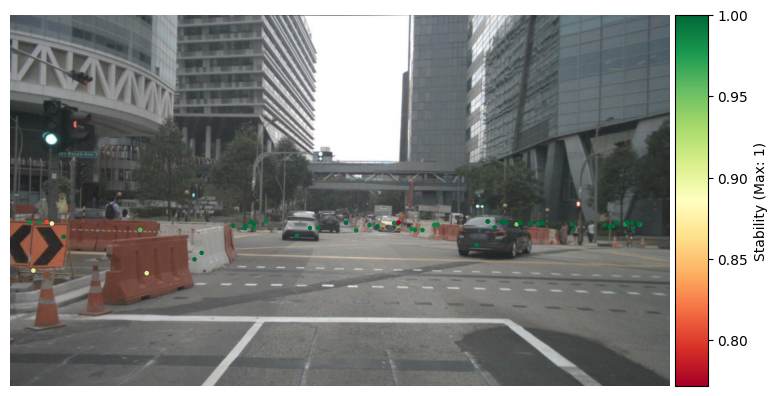

In [19]:
render_pointcloud_in_image(nusc, sps_map, get_next_sample(sample)['token'], pointsensor_channel='RADAR_FRONT', out_path='frame.png')

In [17]:
# setup_directories(scene_name)
# save_plots_for_scene(nusc, scene_name, sample_token, sps_map, '')
# create_video_from_plots(scene_name)

In [ ]:
# name = 'scene_0108-0341_combined'
# # setup_directories(name, subdirs=True)
# sps103_map = np.loadtxt('scene_0103-0341_combined/scene-0103.asc', delimiter=' ', skiprows=1)
# sps341_map = np.loadtxt('scene_0103-0341_combined/scene-0341.asc', delimiter=' ', skiprows=1)
# save_plots_for_scene(nusc, name, '3e8750f331d7499e9b5123e9eb70f2e2', sps103_map, 'scene1')
# save_plots_for_scene(nuscenes_exp['test'], name, 'e3ebfa2c35794e00b6d67401b50dda01', sps341_map, 'scene2')
# create_video_from_plots(name)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from nuscenes.utils.geometry_utils import view_points, transform_matrix
from pyquaternion import Quaternion
from matplotlib.animation import FuncAnimation, PillowWriter

import os.path as osp


def points_in_box(corners, points: np.ndarray, wlh_factor: float = 1.0):
    """
    Checks whether points are inside the box.

    Picks one corner as reference (p1) and computes the vector to a target point (v).
    Then for each of the 3 axes, project v onto the axis and compare the length.
    Inspired by: https://math.stackexchange.com/a/1552579
    :param box: <Box>.
    :param points: <np.float: 3, n>.
    :param wlh_factor: Inflates or deflates the box.
    :return: <np.bool: n, >.
    """

    p1 = corners[:, 0]
    p_x = corners[:, 4]
    p_y = corners[:, 1]
    p_z = corners[:, 3]

    i = p_x - p1
    j = p_y - p1
    k = p_z - p1

    v = points - p1.reshape((-1, 1))

    iv = np.dot(i, v)
    jv = np.dot(j, v)
    kv = np.dot(k, v)

    mask_x = np.logical_and(0 <= iv, iv <= np.dot(i, i))
    mask_y = np.logical_and(0 <= jv, jv <= np.dot(j, j))
    mask_z = np.logical_and(0 <= kv, kv <= np.dot(k, k))
    mask = np.logical_and(np.logical_and(mask_x, mask_y), mask_z)

    return mask


def process_scene(nusc: NuScenes, scene_token: str, distance_threshold: float = 1.0, zoom_level: int = 5):
    scene_record = nusc.get('scene', scene_token)
    sample_token = scene_record['first_sample_token']
    frames = []
    radar_map = []

    while sample_token != '':
        sample = nusc.get('sample', sample_token)
        radar_sample_data_tokens = [sample['data'][c] for c in sensors]  # Use the appropriate radar sensor channel
        lidar_sample_data_token = sample['data']['LIDAR_TOP']  # Use the appropriate LiDAR sensor channel

        # Project LiDAR points to global frame
        lidar_sd_record = nusc.get('sample_data', lidar_sample_data_token)
        pcl_path = osp.join(nusc.dataroot, lidar_sd_record['filename'])
        pc = LidarPointCloud.from_file(pcl_path)
        
        cs_record = nusc.get('calibrated_sensor', lidar_sd_record['calibrated_sensor_token'])
        pose_record = nusc.get('ego_pose', lidar_sd_record['ego_pose_token'])
        
        global_from_car = transform_matrix(pose_record['translation'], Quaternion(pose_record['rotation']))
        car_from_sensor = transform_matrix(cs_record['translation'], Quaternion(cs_record['rotation']))
        
        lidar_sensor_to_global = np.dot(global_from_car, car_from_sensor)
        lidar_points = view_points(pc.points[:3, :], lidar_sensor_to_global, normalize=False)

        # Get radar points in global frame
        all_points = []
        for token in radar_sample_data_tokens:
            radar_sd_record = nusc.get('sample_data', token)
            radar_sample_rec = nusc.get('sample', radar_sd_record['sample_token'])
            radar_pc, times = RadarPointCloud.from_file_multisweep(nusc, radar_sample_rec, radar_sd_record['channel'], 'RADAR_FRONT')
            all_points.append(radar_pc.points)
        all_points = np.hstack(all_points)
        
        radar_pc_all = RadarPointCloud(all_points)
        
        
        radar_cs_record = nusc.get('calibrated_sensor', radar_sd_record['calibrated_sensor_token'])
        pose_record = nusc.get('ego_pose', radar_sd_record['ego_pose_token'])
        
        global_from_car = transform_matrix(pose_record['translation'], Quaternion(pose_record['rotation']))
        car_from_sensor = transform_matrix(radar_cs_record['translation'], Quaternion(radar_cs_record['rotation']))
        
        sensor_to_global = np.dot(global_from_car, car_from_sensor)
        radar_points = view_points(radar_pc_all.points[:3, :], sensor_to_global, normalize=False)

        # Render radar and lidar points
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        ax.scatter(radar_points[0, :], radar_points[1, :], c='blue', s=1, label='Radar Points')
        ax.scatter(lidar_points[0, :], lidar_points[1, :], c='red', s=1, label='LiDAR Points')

        _, boxes, _ = nusc.get_sample_data(lidar_sample_data_token, use_flat_vehicle_coordinates=False)
        # Transform boxes to the global frame
        for box in boxes:
            c = 'black' #np.array(nusc.get_color(box.name)) / 255.0
            box.render(ax, view=lidar_sensor_to_global, colors=(c, c, c))
            # Add class labels
            corners = view_points(box.corners(), lidar_sensor_to_global, False)
            ax.text(corners[0, 0], corners[1, 0], box.name, color='green')
            
            # Check which radar points lie within this box
            in_box_mask = points_in_box(corners, radar_points)            
            stable_labels = 1 - in_box_mask.astype(int)
            radar_pc_sps = np.vstack([radar_points[:3, :], stable_labels])
            radar_map.append(radar_pc_sps.T)
            radar_points_in_box = radar_points[:, in_box_mask]
            ax.scatter(radar_points_in_box[0, :], radar_points_in_box[1, :], c='yellow', s=1)

        # ax.plot(0, 0, 'x', color='red')
        # ax.set_xlim(-40, 40)
        # ax.set_ylim(-40, 40)

        if zoom_level != -1:
            all_pos = np.hstack([radar_points[:3,:], lidar_points[:3,:]]).T
            x_mean = np.mean(all_pos[:,0])
            y_mean = np.mean(all_pos[:,1])
            x_std = np.std(all_pos[:,0])
            y_std = np.std(all_pos[:,1])
            
            std_dev_range = zoom_level

            x_limits = [x_mean - std_dev_range*x_std, x_mean + std_dev_range*x_std]
            y_limits = [y_mean - std_dev_range*y_std, y_mean + std_dev_range*y_std]

            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)

        ax.set_title('Radar and LiDAR Points in Global Frame with LiDAR detections')
        ax.legend()
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
        ax.margins(0,0)

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)
        
        # plt.show()

        # Associate radar and lidar points
        associations = []
        for i, radar_point in enumerate(radar_points.T):
            distances = np.linalg.norm(lidar_points.T - radar_point, axis=1)
            min_distance = np.min(distances)
            if min_distance < distance_threshold:
                lidar_index = np.argmin(distances)
                associations.append((i, lidar_index))

        print(f'Frame {sample_token}: {len(associations)} associations found')

        sample_token = sample['next']
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.margins(0,0)
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_array(frame)
        return [im]
    
    ani = FuncAnimation(fig, update, frames=frames, blit=True)
    plt.close(fig)
    return ani, radar_map

# Example usage
scene_token = dataset_sequence.scene['token']
ani, radar_map = process_scene(nuscenes_exp['trainval'], scene_token, zoom_level=5)
# writer = PillowWriter(fps=2)
# ani.save('scene_animation.gif', writer=writer)

Frame c525629d7b3749d8968b486bb5412adf: 14 associations found
Frame 273f8288e5bf48ef835a1b71839f95ff: 84 associations found
Frame 005d3e821c4e4e0ab03f1ea1dcbf9cc8: 88 associations found
Frame f1a2b04d085842dfa616d66eb41f1dac: 86 associations found
Frame 14ab15e6c6fa4ac5a925b3b3d5057a69: 74 associations found
Frame 686d05b40a9c4e0787ad4d7d9a34b7e2: 60 associations found
Frame 8613eaa60fdb40e7b7564f4bd1a0a713: 71 associations found
Frame c7b18ce7027c4cc3b2068fbf46860b3f: 83 associations found
Frame ed00973ef2814a90b76417d73362c2ed: 110 associations found
Frame c81a1a2b42f04905a14373fcb4842658: 114 associations found
Frame f2b4bd49dd73457395591ff69ac90dec: 140 associations found
Frame d8866c75f88a4dbaa461260b81409544: 151 associations found
Frame 80dda70f1eb04a0cabbbafe1318e4a88: 112 associations found
Frame bd5f50d1b5ce496f9c86018e9681c854: 140 associations found
Frame ece036de967b4e73bc8d76d60d2d6852: 162 associations found
Frame a29623dd054b4177a9d98b83c0fd23bd: 203 associations found


In [13]:
radar_map = np.concatenate(radar_map)

np.save('scene-0345_lidar_labels.npy', radar_map)

In [16]:
np.load('scene-0151_lidar_labels.npy').shape

(2963994, 4)

In [ ]:
from IPython.display import HTML

HTML(ani.to_jshtml())

In [ ]:
video_path = "scene_0172-0210_combined/output_video.avi"

# Display the video
HTML(f"""
<video width="800" height="600" controls>
  <source src="{video_path}" type="video/avi">
  Your browser does not support the video tag.
</video>
""")